In [59]:
import tensorflow as tf
import numpy as np
import os
import PIL
import PIL.Image
import pathlib

In [81]:
train_folder_path = pathlib.Path('D:/Documentos/Polito/Thesis/Datasets/A3LIS-147_italian/trimmed-10/hei-train/left/')
test_folder_path = pathlib.Path('D:/Documentos/Polito/Thesis/Datasets/A3LIS-147_italian/trimmed-10/hei-test/left/')

In [82]:
images = list(train_folder_path.glob('*/*.jpg'))
image_count = len(images)
print(image_count)

79


(152, 152)


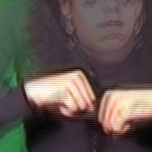

In [83]:
abitare = list(train_folder_path.glob('abitare/*'))
image = PIL.Image.open(str(abitare[0]))
print(image.size)
image

(84, 84)


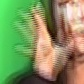

In [84]:
acqua = list(train_folder_path.glob('*acqua/*'))
image = PIL.Image.open(str(acqua[1]))
print(image.size)
image

In [85]:
images_sizes = [PIL.Image.open(image).size[0] for image in images]
images_sizes[:10]

[88, 86, 88, 116, 92, 104, 108, 118, 152, 80]

In [86]:
min(images_sizes)

56

In [87]:
video_shape = (576, 720)
video_area = video_shape[0]*video_shape[1]
images_areas = np.square(images_sizes)

In [88]:
area_ratio = np.round(images_areas/video_area, 3)
average_ratio = np.round(np.mean(area_ratio), 3)
average_ratio

0.027

In [89]:
np.round(np.mean(images_sizes))

104.0

In [161]:
batch_size = 5
img_height = 104
img_width = 104

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
  train_folder_path,
  validation_split=0.15,
  subset="both",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 79 files belonging to 10 classes.
Using 68 files for training.
Using 11 files for validation.


In [71]:
class_names = train_ds.class_names

In [169]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_folder_path,
  image_size=(img_height, img_width),
  batch_size=32)

Found 20 files belonging to 10 classes.


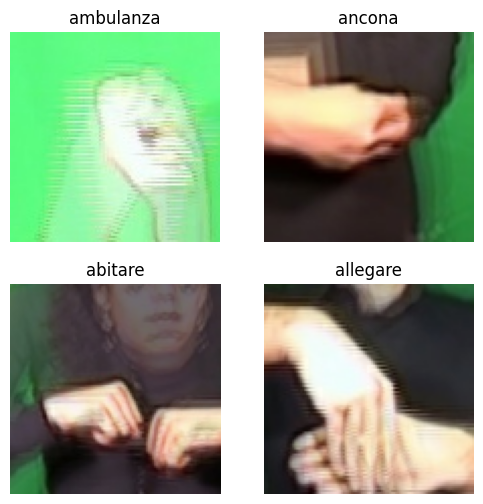

In [58]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
for images, labels in train_ds.take(1):
  for i in range(4):
    ax = plt.subplot(2, 2, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [166]:
image_batch, labels_batch = next(iter(train_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 255.0


In [139]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.31764707 1.0


In [140]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
# test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [131]:
num_classes = 10

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [132]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [133]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=15
)

Epoch 1/15


14/14 [==============================] - 3s 42ms/step - loss: 2.3669 - accuracy: 0.1618 - val_loss: 2.2855 - val_accuracy: 0.0000e+00
Epoch 2/15
14/14 [==============================] - 0s 36ms/step - loss: 2.2254 - accuracy: 0.2059 - val_loss: 2.2680 - val_accuracy: 0.0909
Epoch 3/15
14/14 [==============================] - 0s 35ms/step - loss: 1.9121 - accuracy: 0.4118 - val_loss: 1.7254 - val_accuracy: 0.5455
Epoch 4/15
14/14 [==============================] - 0s 34ms/step - loss: 1.1966 - accuracy: 0.5588 - val_loss: 1.3483 - val_accuracy: 0.7273
Epoch 5/15
14/14 [==============================] - 0s 34ms/step - loss: 0.7621 - accuracy: 0.7647 - val_loss: 1.3787 - val_accuracy: 0.6364
Epoch 6/15
14/14 [==============================] - 0s 35ms/step - loss: 0.4108 - accuracy: 0.8235 - val_loss: 1.5011 - val_accuracy: 0.5455
Epoch 7/15
14/14 [==============================] - 0s 34ms/step - loss: 0.2999 - accuracy: 0.9118 - val_loss: 1.6426 - val_accuracy: 0.6364
Epoch 8/15
14/14 [==

In [149]:
len(test_ds)

4

In [153]:
class_names

['abbonamento',
 'abitare',
 'acqua',
 'affitto',
 'allegare',
 'allergia',
 'ambulanza',
 'amministrazione',
 'ancona',
 'andata']

In [171]:
image_batch, labels_batch = next(iter(test_ds))
labels_batch

<tf.Tensor: shape=(20,), dtype=int32, numpy=array([2, 4, 3, 3, 9, 8, 5, 1, 5, 0, 4, 7, 9, 6, 6, 1, 8, 2, 7, 0])>

In [174]:
x, y = next(iter(test_ds))
predictions = np.argmax(model.predict(x), axis=-1)
labels = y

m = tf.keras.metrics.Accuracy()
m.update_state(predictions, labels)
m.result().numpy()

1/1 [==============================] - 0s 42ms/step


0.75

Label: abbonamento
Prediction: abbonamento


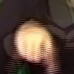




Label: abbonamento
Prediction: amministrazione


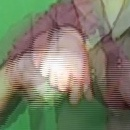




Label: abitare
Prediction: abitare


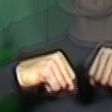




Label: abitare
Prediction: abitare


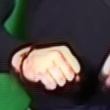




Label: acqua
Prediction: acqua


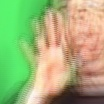




Label: acqua
Prediction: acqua


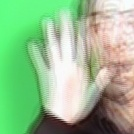




Label: affitto
Prediction: affitto


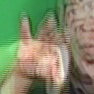




Label: affitto
Prediction: abbonamento


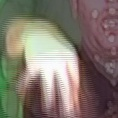




Label: allegare
Prediction: allegare


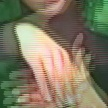




Label: allegare
Prediction: allegare


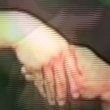




Label: allergia
Prediction: allergia


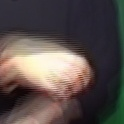




Label: allergia
Prediction: allergia


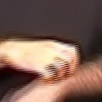




Label: ambulanza
Prediction: ambulanza


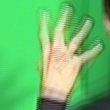




Label: ambulanza
Prediction: ambulanza


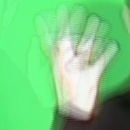




Label: amministrazione
Prediction: amministrazione


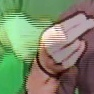




Label: amministrazione
Prediction: amministrazione


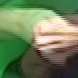




Label: ancona
Prediction: amministrazione


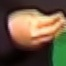




Label: ancona
Prediction: ancona


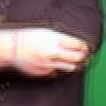




Label: andata
Prediction: acqua


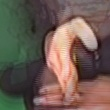




Label: andata
Prediction: ambulanza


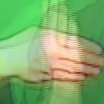

In [226]:
for path in test_folder_path.iterdir():
    for file in path.iterdir():
        print(f'Label: {path.name}')
        image = PIL.Image.open(file)
        image_array = tf.image.resize(image, [104,104])
        image_array = np.expand_dims(image_array, axis=0)
        print(f'Prediction: {class_names[int(np.argmax(model.predict(image_array, verbose=0)))]}')
        display(image)
        print('\n\n')
